In [63]:
import os
import sys
import time
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

from scipy.signal import welch, firwin, filtfilt, hilbert
from time import gmtime
from statsmodels.tsa.api import SimpleExpSmoothing

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step', 'f', 'record']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [64]:
sys.path.insert(0, '/Users/wassilyminkow/Scripts/Python3/')

from Neuroinformatics.torpor_project.data import *
from Neuroinformatics.math.pandas.statistics import *
from Neuroinformatics.data.pandas.time_series import TimeSeries
from Neuroinformatics.math.curves import *
from Neuroinformatics.math.regression import *

In [65]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [123]:
path = "/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/"

In [124]:
paths = {}
for folder in os.walk(path):
    key = folder[0].split(os.path.sep)[-1]
    li = []
    for file in folder[2:][0]:
        if file.split('.')[-1] == "bdf":
            li.append(os.path.join(folder[0], file))
    if len(li) > 0:
        paths[key] = li

In [125]:
for key, value in paths.items():
    print(key, value)

#5+ ['/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#5+/15-04-2019_21-31.bdf', '/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#5+/17-04-2019_20-41.bdf']
#6- ['/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#6-/15-04-2019_20-41.bdf', '/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#6-/17-04-2019_20-42.bdf']
#7+ ['/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#7+/15-04-2019_21-34.bdf', '/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#7+/17-04-2019_20-43.bdf']
#8- ['/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#8-/15-04-2019_21-38.bdf', '/Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#8-/17-04-2019_20-46.bdf']


In [126]:
min_per_epoch = 10
total_hours = 6
order = 400 # filter order
a = 1 
bands = np.array([[1, 4], [4, 8]]) 
chans = ["Channel 1", "Channel 2"]
kinds = [
    "Power", 
    "Power {}-{}".format(bands[0,0], bands[0,1]), 
    "Power {}-{}".format(bands[1,0], bands[1,1]),
        ]

data = []
for chan in chans:
    for kind in kinds:
        data.append("{} {}".format(chan, kind))        
data.append("Acceleration")
data.append("Subject")
data.append("Record")

data = pd.DataFrame(columns=data)

start_epoc = 0
counter = 0

for key, value in paths.items():
    for name in value:

        # read EEG and acceleration data
        raw_data = mne.io.read_raw_edf(name)
            
        fs = round(raw_data.info['sfreq'])
        df = pd.DataFrame(raw_data.get_data().T, columns=raw_data.info["ch_names"])        

        # Calculate # of polygraphy epochs and correspotding # of EEG samples for the  EEG file
#         n_epocs = int(np.floor(df.shape[0]/fs/SEC_PER_MIN/min_per_epoch))
#         n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Calculate # of epochs and correspotding # of EEG samples for the EEG file for 6 hours
        n_epocs = 36
        n_samples = int(n_epocs*min_per_epoch*SEC_PER_MIN*fs)

        # Skip damaged samples at the ending
        df_epocs = df.iloc[:n_samples, :]

        # Polygraphy epoch length in EEG samples.
        step = fs*SEC_PER_MIN*min_per_epoch

        data_new = {}
        
        for chan in chans:

            # low-pass filter
            b = firwin(order, bands[0, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_lo = filtfilt(b, a, df_epocs[chan].iloc[:]) # apply filter
            
            # high-pass filter
            b = firwin(order, bands[1, :] * 2 / fs, width=None, window='hamming', pass_zero=False) # design filter
            df_epocs_hi = filtfilt(b, a, df_epocs[chan].iloc[:])
            
            # band power data
            data_new.update({
                "{} {}".format(chan, kinds[0]): np.array(list(map(lambda i: (df_epocs[chan].iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[1]): np.array(list(map(lambda i: (df_epocs_lo[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
                "{} {}".format(chan, kinds[2]): np.array(list(map(lambda i: (df_epocs_hi[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs)))),
            })
            
            del df_epocs_lo, df_epocs_hi

        acc_sign = df_epocs["STI 014"].diff().fillna(0)    
        
        # acceleration data
        data_new.update({
            "Acceleration": np.array(list(map(lambda i: (acc_sign.iloc[i*step:(i+1)*step]**2).mean(), np.arange(n_epocs))))
                        })
        
        data_new = pd.DataFrame(data_new)
        data_new["Subject"] = key
        data_new["Record"] = name.split('/')[-1][:-10]
        
        data = pd.concat([data, data_new])
        
        start_epoc += n_epocs
        counter += 1
        
data = data.reset_index(drop=True)

Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#5+/15-04-2019_21-31.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#5+/17-04-2019_20-41.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#6-/15-04-2019_20-41.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#6-/17-04-2019_20-42.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.
/Users/wassilyminkow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#7+/15-04-2019_21-34.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#7+/17-04-2019_20-43.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#8-/15-04-2019_21-38.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


Extracting EDF parameters from /Volumes/My Passport/data/2019_lactate/6_D-L/right comp/#8-/17-04-2019_20-46.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-126-e8f6f1041c45>:30: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(name)


In [127]:
data.to_csv("6_D-L_right_comp.csv")

In [316]:
l_lactate = [
    "l-lactat_3_5_6.csv",
    "3_L-L.csv",
    "lactate.csv"
]

d_lactate = [
    "1_D-L.csv",
    "2_D-L.csv",
    "4_D-L.csv",
    "5_D-L.csv",
    "6_D-L_left_comp.csv",
    "6_D-L_right_comp.csv",
    "D-Lactate_2018_10.csv",
]

In [429]:
del data

counter = 1

for n, df in enumerate(d_lactate):
    data = pd.read_csv(df)
    
    for i, sub in enumerate(data["Subject"].unique()): 
        data = data.replace(sub, f"S{counter}")
        counter += 1
        
    for i, sub in enumerate(data["Subject"].unique()):
    
        rec = data[data["Subject"]==sub]["Record"].unique()
        
        print(rec)
        
        if rec[0] != 'Day 1' and rec[0] != 'Day 2':
            
            if int(rec[0].split("-")[1]) < int(rec[1].split("-")[1]):
                data = data.replace(rec[0], "Day 1")
                data = data.replace(rec[1], "Day 2")
            elif int(rec[0].split("-")[1]) > int(rec[1].split("-")[1]):
                data = data.replace(rec[1], "Day 1")
                data = data.replace(rec[0], "Day 2")
            elif int(rec[0].split("-")[0]) < int(rec[1].split("-")[0]):
                data = data.replace(rec[0], "Day 1")
                data = data.replace(rec[1], "Day 2")
            elif int(rec[0].split("-")[0]) > int(rec[1].split("-")[0]):
                data = data.replace(rec[1], "Day 1")
                data = data.replace(rec[0], "Day 2")
              
    data.to_csv(f"d{n}.csv")   
    
d_new = [f"d{i}.csv" for i in range(len(d_lactate))]
data = pd.concat(list(map(lambda x: pd.read_csv(x), d_new)))

['01-02-2019' '31-01-2019']
['Day 2' 'Day 1']
['Day 2' 'Day 1']
['Day 2' 'Day 1']
['22-02-2019' '26-02-2019']
['19-03-2019' '21-03-2019']
['Day 1' 'Day 2']
['02-04-2019' '04-04-2019']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['15-04-2019_20' '17-04-2019_19-']
['Day 1' 'Day 2']
['15-04-2019' '17-04-2019']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['15-10-2018' '17-10-2018']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['Day 1' 'Day 2']


In [433]:
del data

counter = 1

for n, df in enumerate(l_lactate):
    data = pd.read_csv(df)
    
    for i, sub in enumerate(data["Subject"].unique()): 
        data = data.replace(sub, f"S{counter}")
        counter += 1
        
    for i, sub in enumerate(data["Subject"].unique()):
    
        rec = data[data["Subject"]==sub]["Record"].unique()
        
        print(rec)
        
        if rec[0] != 'Day 1' and rec[0] != 'Day 2':
            
            if int(rec[0].split("-")[1]) < int(rec[1].split("-")[1]):
                data = data.replace(rec[0], "Day 1")
                data = data.replace(rec[1], "Day 2")
            elif int(rec[0].split("-")[1]) > int(rec[1].split("-")[1]):
                data = data.replace(rec[1], "Day 1")
                data = data.replace(rec[0], "Day 2")
            elif int(rec[0].split("-")[0]) < int(rec[1].split("-")[0]):
                data = data.replace(rec[0], "Day 1")
                data = data.replace(rec[1], "Day 2")
            elif int(rec[0].split("-")[0]) > int(rec[1].split("-")[0]):
                data = data.replace(rec[1], "Day 1")
                data = data.replace(rec[0], "Day 2")
              
    data.to_csv(f"l{n}.csv")   
    
l_new = [f"l{i}.csv" for i in range(len(l_lactate))]
data = pd.concat(list(map(lambda x: pd.read_csv(x), l_new)))

['14-03-2018' '19-03-2018']
['15-05-2018' '17-05-2018']
['01-06-2018' '04-06-2018']
['05-03-2019' '07-03-2019']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['Day 1' 'Day 2']
['01-02-2019' '31-01-2019']
['Day 2' 'Day 1']
['Day 2' 'Day 1']
['Day 2' 'Day 1']


In [383]:
data = pd.concat(list(map(lambda x: pd.read_csv(x), d_lactate)))

In [320]:
pylab.rcParams['figure.figsize'] = (22, 18)
sns.set(font_scale=2.5)

In [322]:
pylab.rcParams['figure.figsize'] = (22, 9)
sns.set(font_scale=1.5)

In [435]:
uq = data["Subject"].unique()
p_value = np.ones(uq.shape[0])

for i, sub in enumerate(uq):
    
    x = data[(data["Subject"]==sub) & (data["Record"]=="Day 1")]["Acceleration"]
    y = data[(data["Subject"]==sub) & (data["Record"]=="Day 2")]["Acceleration"]
    
    corr_th = 0.05/uq.shape[0]
    if wilcoxon(x, y)[1] < corr_th:
        data = data.replace(sub, sub+"+")

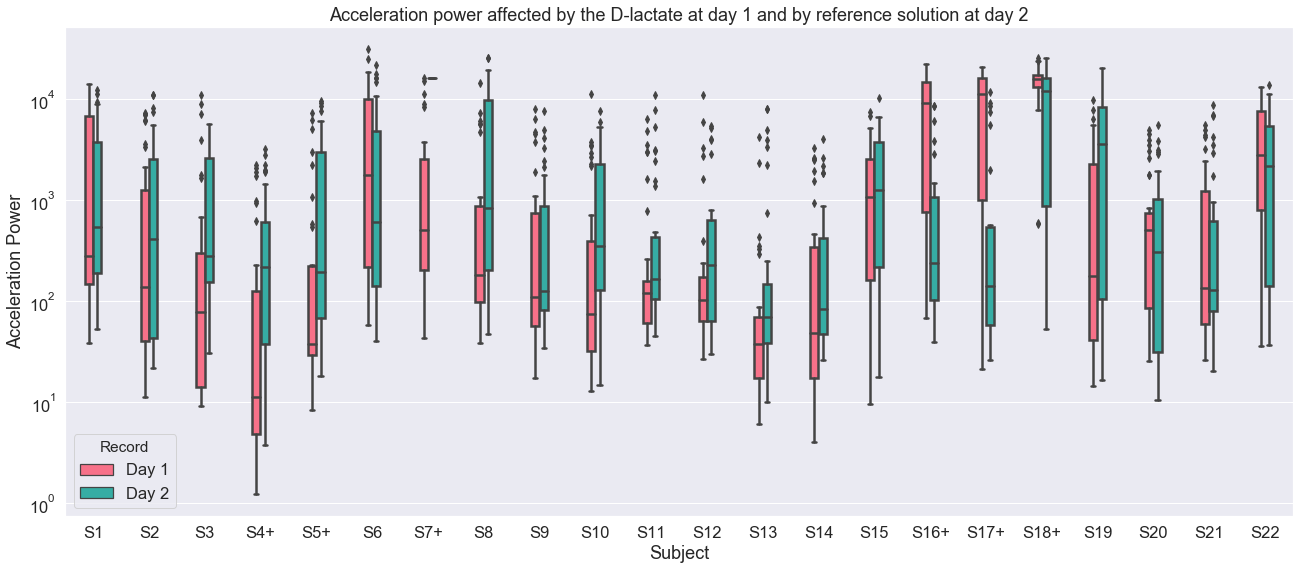

In [432]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Subject", 
            y="Acceleration", 
            hue="Record",
            hue_order=['Day 1', 'Day 2'],
            palette="husl",
            linewidth=2.5,
            saturation=1,
            width=0.3,
            data=data, 
            ax=ax)
title("Acceleration power affected by the D-lactate at day 1 and by reference solution at day 2")
ax.set_ylabel("Acceleration Power")
show()

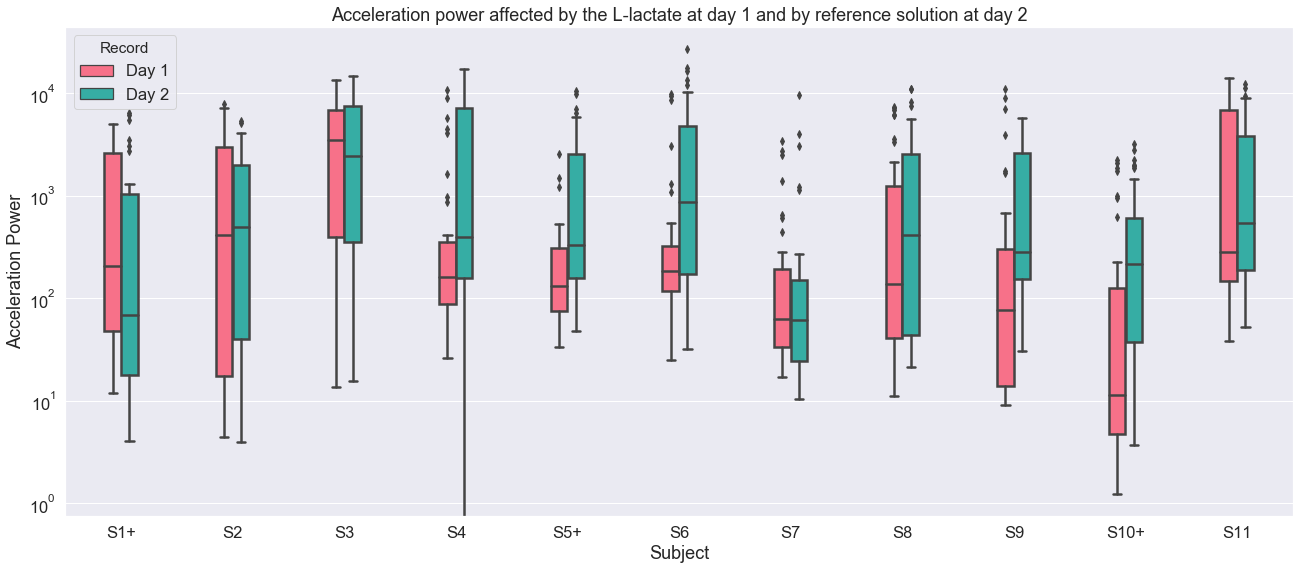

In [436]:
f, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="Subject", 
            y="Acceleration", 
            hue="Record",
            hue_order=['Day 1', 'Day 2'],
            palette="husl",
            linewidth=2.5,
            saturation=1,
            width=0.3,
            data=data, 
            ax=ax)
title("Acceleration power affected by the L-lactate at day 1 and by reference solution at day 2")
ax.set_ylabel("Acceleration Power")
show()

In [421]:
cm = pd.DataFrame({"L-Lactate":[1, 2], "D-Lactate":[3, 3]}, index=["Day 1", "Day 2"] )

In [425]:
cm 

,L-Lactate,D-Lactate
Day 1,1,3
Day 2,2,3


In [424]:
fisher_exact(cm)

(0.5, 1.0)

In [423]:
from scipy.stats import fisher_exact

/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/vasilyminkov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.
/Users/vasilyminkov/anaconda3/lib/pyt

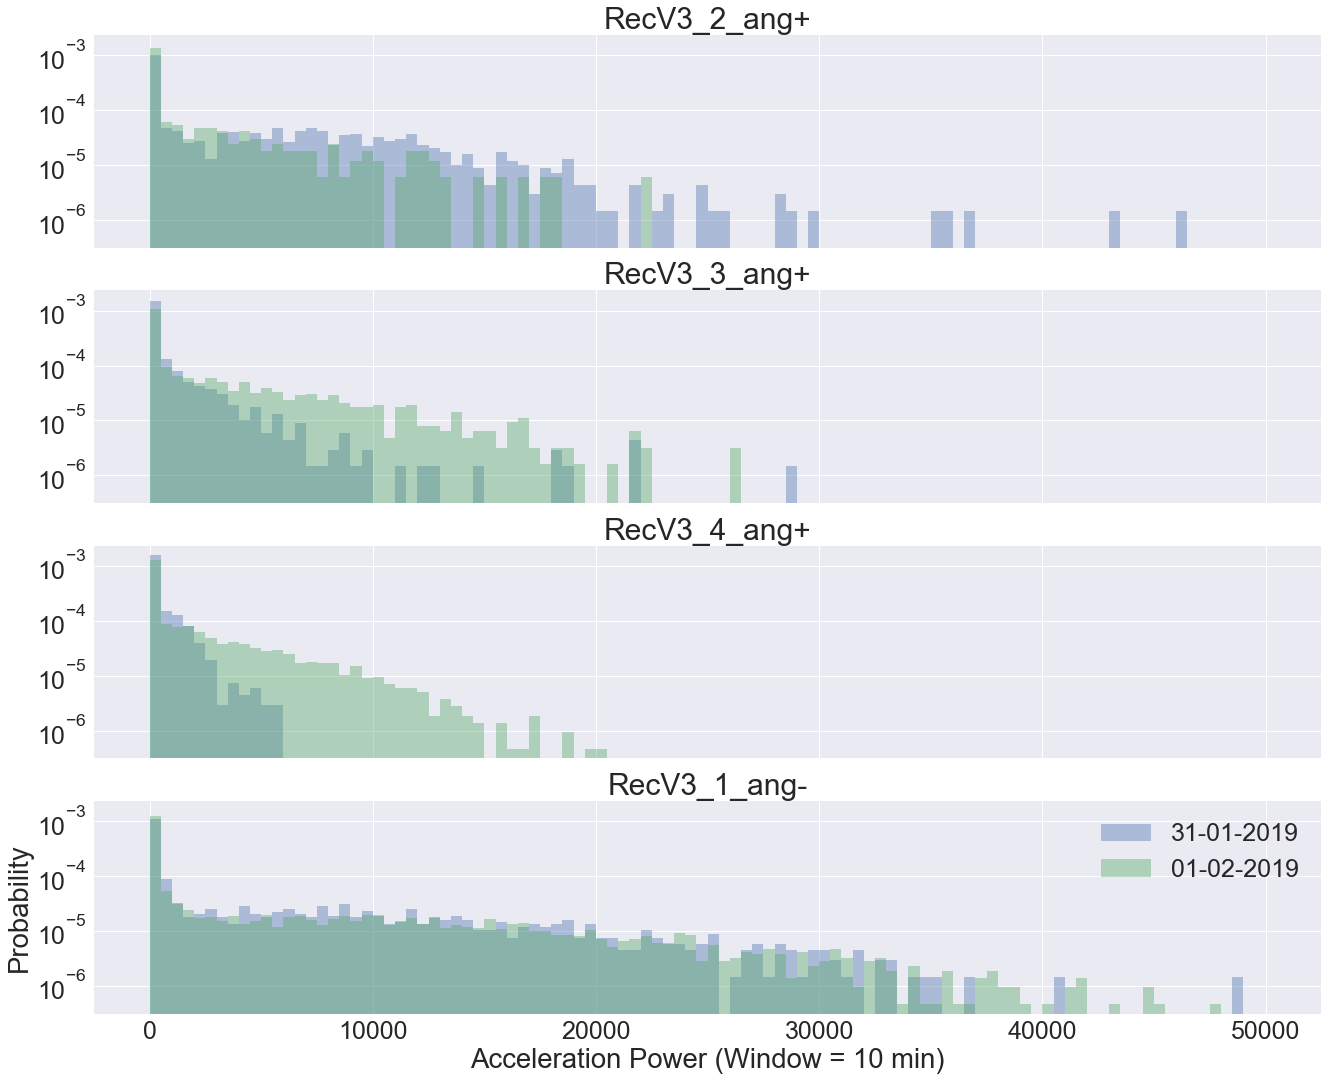

In [38]:
f, ax = plt.subplots(4, 1, sharex=True, sharey=True)

for subject_id, subject_name in enumerate(data["Subject"].unique()):
    
    subject = data[data["Subject"]==subject_name]
    ax[subject_id].set(yscale="log")
    ax[subject_id].set_title(subject_name)
    
    for record_name in subject["Record"].unique()[::-1]:        
        
        sns.distplot(
            subject[subject["Record"]==record_name]["Acceleration"].as_matrix(),
            kde=False,
            bins=100,
            norm_hist=True,
            ax=ax[subject_id],
            hist_kws={"range": [0, 5e4], "label":record_name},
        )
        
    legend()
    xlabel("Acceleration Power (Window = 10 min)")
    ylabel("Probability")